## Stock Return Prediction

For this project, I used various supervised learning-based models to predict the
stock price of Microsoft using correlated assets and its own historical data.
### Note: The presentation of this project has been arranged in such a way that, anybody can follow and learn from it. Kindly quote me if you're using any part of my work for research or academic purposes.

<a id='0'></a>
# 1. Problem Definition

Using a supervised regression framework used for this project, weekly return of the
Microsoft stock is the predicted variable(target). We need to understand what affects Microsoft stock price and hence incorporate as much information into the model. 

For this project, other than the historical data of Microsoft, the independent variables used are the following potentially correlated assets:
* Stocks: IBM (IBM) and Alphabet (GOOGL)
* Currency: USD/JPY and GBP/USD
* Indices: S&P 500, Dow Jones, VIX and USDollar Index(USDX)
Note: The value of USDX is a fair indication of the dollar's value in global markets. The idea is to determine if global market have impact on MSFT stock. 


<a id='1'></a>
## 2.0 Loading the data and libraries

<a id='1.1'></a>
## 2.1. Loading the libraries

In [3]:
# Visualization and Data Processing libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

#Data Analysis and Model Evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Supervised regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

Next, we extract the data required for our analysis using pandas datareader. "FRED": Federal Reserve Economic Data from St. Louis website

In [5]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2022,3,31)
stk_tickers = ["MSFT","IBM","GOOGL"]
ccy_tickers = ["DEXJPUS", "DEXUSUK"]
idx_tickers = ["SP500","DJIA","VIXCLS","DTWEXBGS"]

stk_data = web.DataReader(stk_tickers,"yahoo",start,end)
ccy_data = web.DataReader(ccy_tickers,"fred",start,end)
idx_data = web.DataReader(idx_tickers,"fred",start,end)

Next, we need a series from historical data to make predictions. We choose to predict using weekly returns. We approximate this by using 5 business trading day period returns which ends on every friday. Bank holiday periods within the business week were removed from the dataset since no trading occurs.

In [6]:
return_period = 5

We now define our Y series and X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Trading Day Returns
    b. IBM 5 Business Trading Day Returns    
    c. USD/JPY 5 Business Trading DayReturns    
    d. GBP/USD 5 Business Trading DayReturns    
    e. S&P 500 5 Business Trading DayReturns    
    f. Dow Jones 5 Business Trading DayReturns    
    g. MSFT 5 Business Trading Day Returns    
    h. MSFT 15 Business Trading Day Returns    
    i. MSFT 30 Business Trading Day Returns    
    j. MSFT 60 Business Day Returns
    k. USDX 5 Business Trading Day Returns

We remove the MSFT past returns when we use the Time series models.

In [7]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [8]:
pd.set_option('precision', 3)
dataset.to_excel("MSFT_stock_price.xlsx") #Extracted dataset saved into ecel file
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,DTWEXBGS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,467.000,467.000,4.670e+02,4.670e+02,4.670e+02,467.000,467.000,467.000,4.670e+02,467.000,467.000,467.000,467.000
mean,0.005,0.005,-2.136e-04,9.150e-04,-4.308e-04,0.002,0.002,0.002,4.381e-04,0.005,0.016,0.031,0.060
std,0.032,0.035,3.142e-02,1.219e-02,1.288e-02,0.021,0.022,0.157,7.113e-03,0.032,0.049,0.066,0.087
min,-0.179,-0.168,-2.312e-01,-4.496e-02,-1.112e-01,-0.198,-0.209,-0.495,-2.122e-02,-0.179,-0.282,-0.229,-0.187
25%,-0.011,-0.016,-1.592e-02,-5.201e-03,-7.327e-03,-0.006,-0.007,-0.084,-3.739e-03,-0.011,-0.012,-0.006,0.006
50%,0.006,0.005,1.606e-03,7.438e-04,-5.608e-04,0.004,0.004,-0.015,3.042e-04,0.006,0.019,0.032,0.068
75%,0.023,0.024,1.668e-02,7.032e-03,7.064e-03,0.013,0.012,0.078,4.244e-03,0.023,0.045,0.072,0.118
max,0.113,0.230,1.178e-01,6.909e-02,5.023e-02,0.099,0.116,0.923,3.723e-02,0.113,0.156,0.264,0.377


In [9]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,DTWEXBGS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2012-04-23,-3.118e-03,-0.014,-0.020,8.662e-03,0.015,-0.002,4.457e-04,-0.030,-0.002,3.291e-02,-0.004,0.004,0.092
2012-04-30,-4.373e-02,0.012,0.042,-1.677e-02,0.008,0.022,2.192e-02,-0.101,-0.008,-3.118e-03,0.029,-0.018,0.073
2012-05-07,9.785e-04,0.004,-0.016,8.767e-04,-0.002,-0.020,-1.564e-02,0.099,0.008,-4.373e-02,-0.014,-0.043,0.003
2012-05-14,-2.424e-02,-0.006,-0.017,-6.261e-04,-0.005,-0.023,-2.437e-02,0.144,0.013,9.785e-04,-0.046,-0.050,-0.020
2012-05-21,-6.407e-03,0.017,-0.008,-6.535e-03,-0.020,-0.017,-1.515e-02,0.006,0.009,-2.424e-02,-0.067,-0.038,-0.050


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 467 entries, 2012-04-23 to 2022-03-22
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSFT_pred  467 non-null    float64
 1   GOOGL      467 non-null    float64
 2   IBM        467 non-null    float64
 3   DEXJPUS    467 non-null    float64
 4   DEXUSUK    467 non-null    float64
 5   SP500      467 non-null    float64
 6   DJIA       467 non-null    float64
 7   VIXCLS     467 non-null    float64
 8   DTWEXBGS   467 non-null    float64
 9   MSFT_DT    467 non-null    float64
 10  MSFT_3DT   467 non-null    float64
 11  MSFT_6DT   467 non-null    float64
 12  MSFT_12DT  467 non-null    float64
dtypes: float64(13)
memory usage: 51.1 KB


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

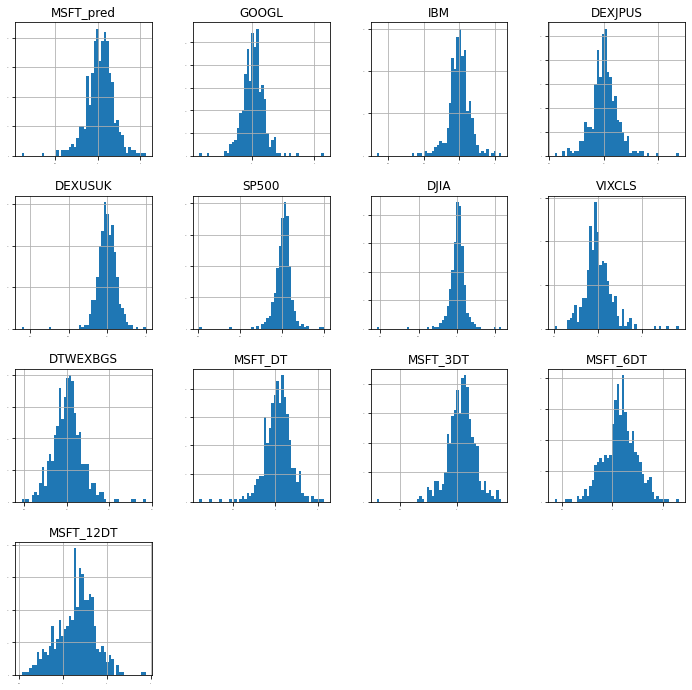

In [11]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

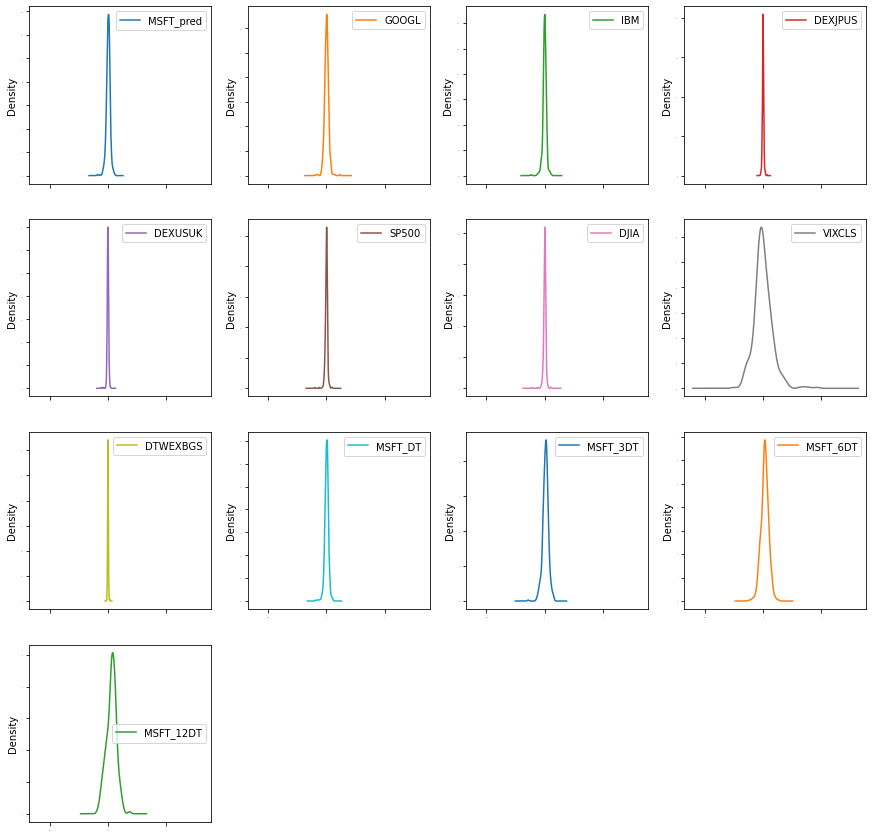

In [12]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

We can see that the VIX has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

<AxesSubplot:title={'center':'Correlation Matrix'}>

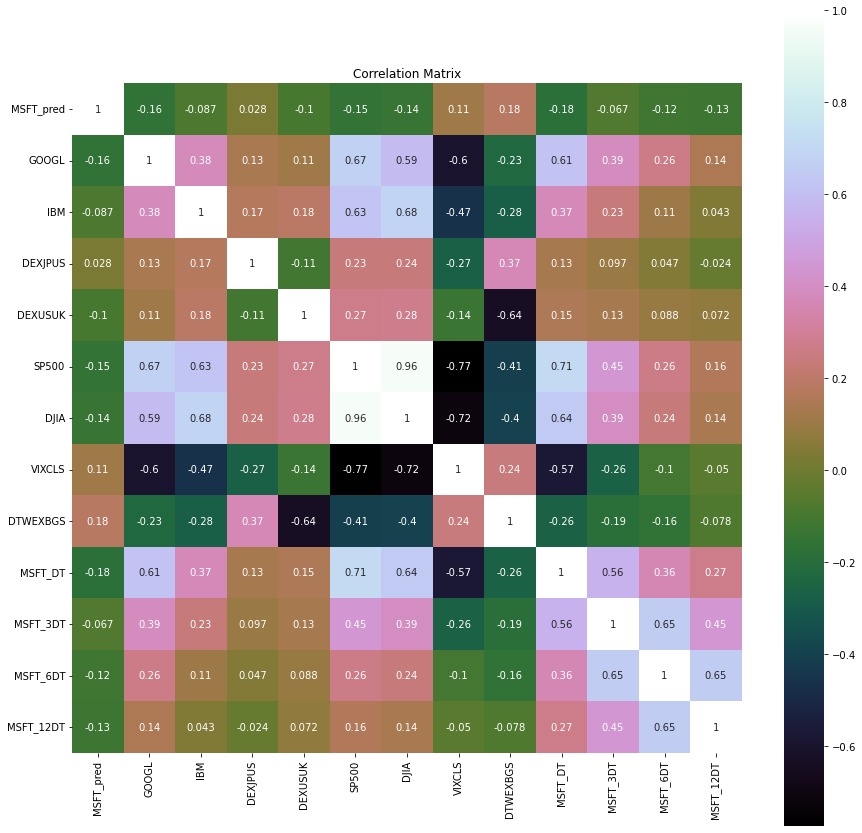

In [13]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot above, we see some correlation of the predicted variable with the lagged 5 days, 15days, 30 days and 60 days return of MSFT. 

<Figure size 1080x1080 with 0 Axes>

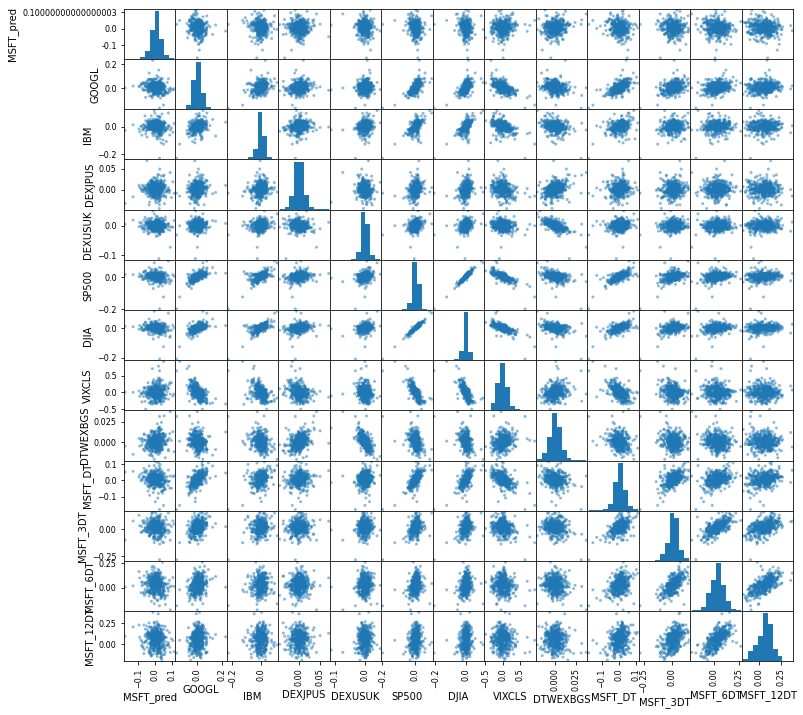

In [14]:
plt.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
plt.show()

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of MSFT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

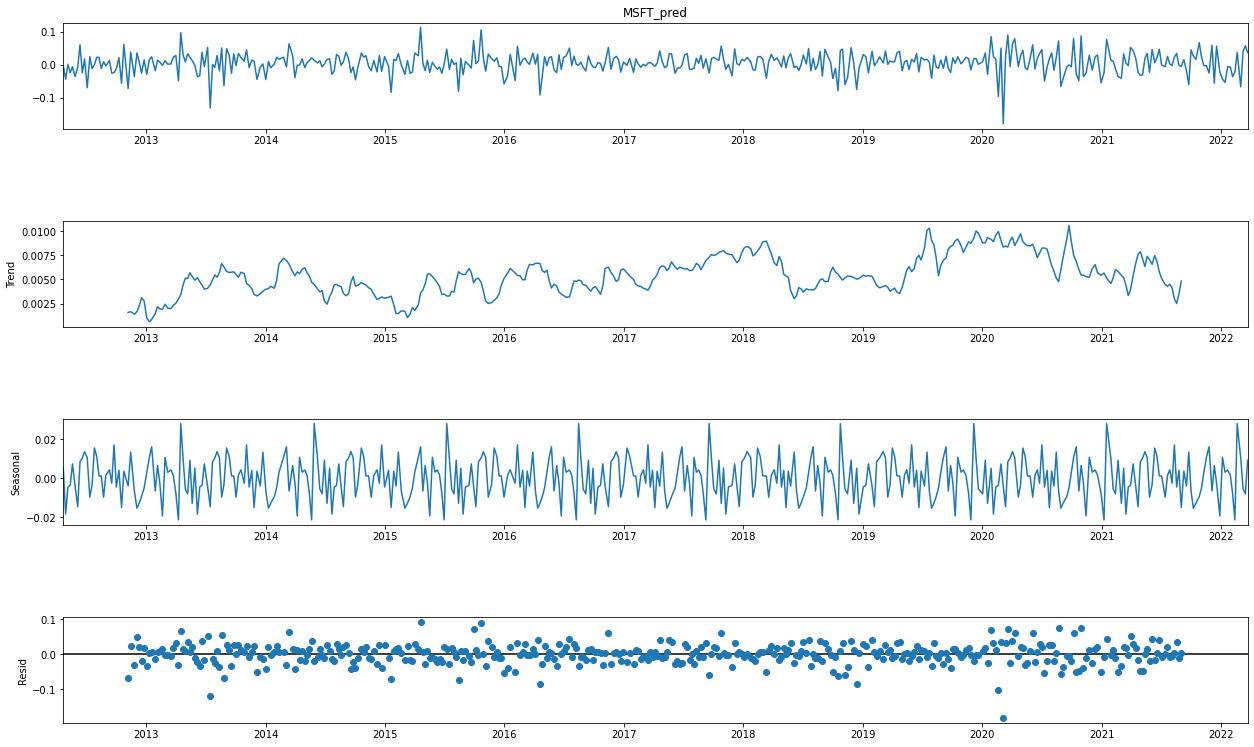

In [17]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(12)
fig.set_figwidth(20)
plt.show()

We can see that for MSFT there has been a general trend upwards. So for 2022, the MSFT stock prediction is anticipated to follow the uptrend till it reaches the resistance level of 0.0075.

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance since it is a supervised learning regression problem.

In [19]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(15,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,15.245
DTWEXBGS,15.106
GOOGL,12.758
SP500,11.084
DJIA,8.963
MSFT_12DT,7.659
MSFT_6DT,6.599
VIXCLS,5.851
DEXUSUK,4.786


We see that MSFT 5 day return seems to be the most important feature and USD/JPY being the least important.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing datasets. Since we are going to use Time series models, then we split the data in continous series.

In [20]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case data is dependent on time series, then train and test dataset becomes:
#X_train,X_test = X[0:train_size], X[train_size:len(X)]
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size],X[train_size:len(X)]
Y_train,Y_test = Y[0:train_size],Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [71]:
num_folds = 10
seed = 7 #this value can be changed to your choice, the importance is when anybody run this code, the values will be consistent
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' #to measure the error of the regression model, you can choose any other scoring model of error measurement.

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Linear, Regularized and Decision Tree Regression algorithms

In [72]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [73]:
models.append(('MLP', MLPRegressor()))

##### Ensemble Models

In [74]:
# Some selected Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Some selected Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset to measure the errors.

In [76]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold,scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000943 (0.000323) 0.029399 0.037552
LASSO: 0.000958 (0.000288) 0.030847 0.036760
EN: 0.000958 (0.000288) 0.030847 0.036760
KNN: 0.001018 (0.000264) 0.026427 0.038846
CART: 0.001816 (0.000484) 0.000000 0.047457
SVR: 0.001579 (0.000273) 0.038630 0.046333
MLP: 0.001194 (0.000504) 0.032019 0.038443
ABR: 0.001057 (0.000312) 0.025141 0.037621
GBR: 0.001038 (0.000322) 0.013419 0.041816
RFR: 0.000992 (0.000283) 0.011695 0.038136
ETR: 0.000951 (0.000280) 0.000000 0.038666


#### K Fold results

We have been looking at the K Fold results and plotting them 

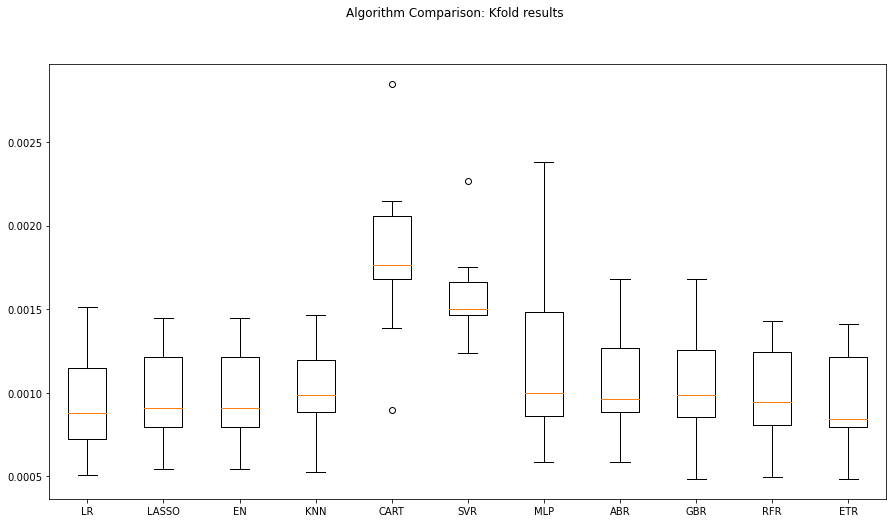

In [77]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

We can see that the linear regression and the regularized regression including the Lasso regression (LASSO) and elastic net (EN) seems to do a good job with minimum error. The line in the boxplot indicates median of the error in each model.

#### Training and Test error

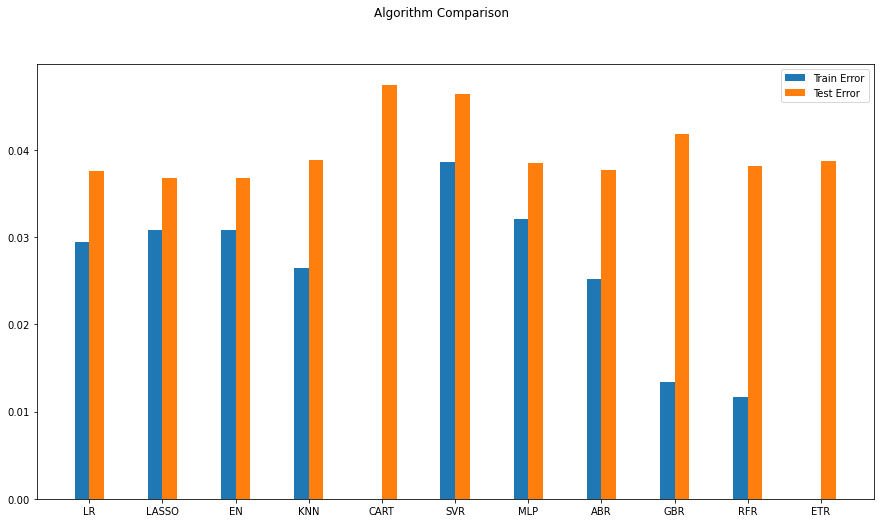

In [78]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.20  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

Looking at the training and test error, we still see a better performance of the linear models. Some of the algorithms, such as the decision tree regressor (CART) overfit on
the training data and produced very high error on the test set and these models
should be avoided. Ensemble models, such as gradient boosting regression (GBR) and
random forest regression (RFR) have low bias but high variance. We also see that the
artificial neural network (shown as MLP in the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [79]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS','DTWEXBGS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS','DTWEXBGS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [80]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [81]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0013857989057724383

###  LSTM Model

In [82]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [83]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

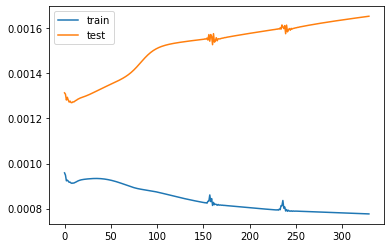

In [86]:
#Visual plot to check if the error is reducing
plt.plot(LSTMModel_fit.history['loss'], label='train')
plt.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [87]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

#### Append to previous results

In [88]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

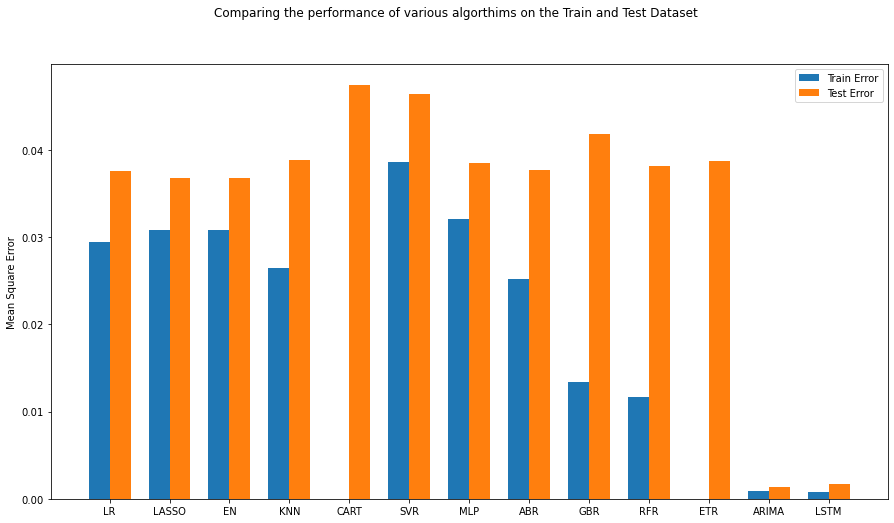

In [89]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [106]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0008892
ARIMA(0, 0, 1) MSE=0.0008816
ARIMA(0, 0, 2) MSE=0.0008784
ARIMA(1, 0, 0) MSE=0.0008801
ARIMA(1, 0, 1) MSE=0.0008786
ARIMA(1, 0, 2) MSE=0.0008783
ARIMA(2, 0, 0) MSE=0.0008784
ARIMA(2, 0, 1) MSE=0.0008699
ARIMA(2, 0, 2) MSE=0.0008668
Best ARIMA(2, 0, 2) MSE=0.0008668


<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [107]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,2])
model_fit_tuned = modelARIMA_tuned.fit()

In [108]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0013857989057724383


After tuning the model and picking the best ARIMA model or the order 2,0 and 2 we select this model and it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [109]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))


In [7]:
#load model from disk
from pickle import load
loaded_model = load(open("finalized_model.sav", "rb"))

In [ ]:
#load model from disk
loaded_model = load(open(filename,"rb"))
#estimate accuracy on validation set
predictions = loaded_model.predict(X_validation#new_example)
result = mean_squared_error(Y_validation,predictions)
print(r2_score(Y_validation,predictions))
print(result)

In [9]:
from scipy.stats import chi2
def get_p_value(G):
    p_value = 1 - chi2.cdf(G, 1)
    return p_value

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are the promising modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this project may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem..
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or company specific news data, which might lead to better results. 

<Figure size 1440x720 with 0 Axes>

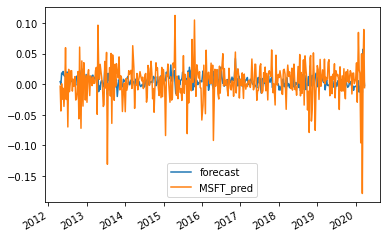

In [110]:
plt.figure(figsize=(20,10))
model_fit_tuned.plot_predict(dynamic=False)
plt.show()

In [111]:
print(model_fit_tuned.summary())

                              ARMA Model Results                              
Dep. Variable:              MSFT_pred   No. Observations:                  373
Model:                     ARMA(2, 2)   Log Likelihood                 785.708
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 14 Apr 2022   AIC                          -1545.415
Time:                        22:46:35   BIC                          -1494.435
Sample:                             0   HQIC                         -1525.171
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0046      0.001      6.360      0.000       0.003       0.006
GOOGL              -0.0423      0.063     -0.671      0.502      -0.166       0.081
IBM                 0.0145      

### Prepared by: Osei Pinamang Kwadwo

Email: osei.pinamang@gmail.com

Linkedin : https://www.linkedin.com/in/oseipinamangkwadwo